---
### Invert with regularization.
Please check the original paper:\
[Felipe A. Bulat, Tim Heaton-Burgess, Aron J. Cohen, and Weitao Yang, J. Chem. Phys. 127, 174101 (2007)](https://aip.scitation.org/doi/full/10.1063/1.2800021?casa_token=-ZgE4QLD_g0AAAAA%3AEKtFcuAPeo8_BGf_3CHsaCfPBletRKQgCgwE87XnpcJzZ1x_TPdeqDTltYzC9Uj9rqcukhbtOgAlhA)\
[Tim Heaton-Burgess, Felipe A. Bulat, and Weitao Yang, PRL 98, 256401 (2007)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.98.256401)

In [1]:
import psi4
import matplotlib.pyplot as plt
import numpy as np

psi4.set_options({"save_jk" : True})
psi4.set_memory(int(2.50e9))
psi4.core.clean()

import n2v

import matplotlib as mpl
mpl.rcParams["font.size"] = 11
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["axes.edgecolor"] = "#eae8e9" 


  Memory set to   2.328 GiB by Python driver.


In [2]:
Ne = psi4.geometry( 
""" 
0 1
Ne
noreorient
nocom
units bohr
symmetry c1
""" )

psi4.set_options({"reference" : "rhf"})  # Spin-Restricted

# IMPORTANT NOTE: psi4.energy does not update cc densities. So we calculate dipole momentes instead.
wfn = psi4.properties("ccsd/cc-pcvdz",  return_wfn=True, molecule=Ne, property=['dipole'])[1]

# Build inverter and set target
ine = n2v.Inverter.from_wfn(wfn, pbs="cc-pcvqz")

#### Result without regularization

In [3]:
# Inverter with WuYang method, guide potention v0=Fermi-Amaldi
ine.invert("WuYang", opt_max_iter=100, opt_method="trust-exact", gtol=1e-4,
           guide_components="fermi_amaldi")

Optimization Successful within 5 iterations! |grad|=5.44e-05


In [4]:
x = np.linspace(-5,5,101)
y = np.zeros_like(x)
z = np.zeros_like(x)
grids = np.array([x,y,z])

vH = ine.eng.grid.esp(grid=grids)[1]
vFA = (1 - 1/(ine.nalpha + ine.nbeta)) * vH

vrest = ine.eng.grid.ao(ine.v_pbs, grid=grids, basis=ine.eng.pbs)

vxc = vFA + vrest - vH

The regularization term
$$\lambda\|{\nabla v_{pbs}}\|^2=\lambda \textbf{b}^T\textbf{T}\textbf{b},$$
where $\textbf{b}$ is the coefficient of $v_{pbs}$ on potential basis set (pbs) and $\textbf{T}$ is the kinetic energy intergral maxtrix in pbs.

This term is subtracted from the Lagrangian.

There are strategies to search for $\lambda$. Accoding to the two paper I cited above,
$$
P(\lambda) = \lambda \frac{\|v_{pbs}(\lambda)\|^2}{L^{\lambda=0}-L^{\lambda}},
$$
is used. where $L$ is the Lagrangian.

In [5]:
lambda_list, P, Ts = ine.find_regularization_constant_wy(opt_max_iter=100, 
                                                      opt_method="trust-exact",
                                                      lambda_list=10 ** np.linspace(-1,-7,21))
print("lambda:\n", lambda_list)
print("P:\n", P)

lambda:
 [1.00000000e-01 5.01187234e-02 2.51188643e-02 1.25892541e-02
 6.30957344e-03 3.16227766e-03 1.58489319e-03 7.94328235e-04
 3.98107171e-04 1.99526231e-04 1.00000000e-04 5.01187234e-05
 2.51188643e-05 1.25892541e-05 6.30957344e-06 3.16227766e-06
 1.58489319e-06 7.94328235e-07 3.98107171e-07 1.99526231e-07
 1.00000000e-07]
P:
 [ 0.03852502  0.0606373   0.08493444  0.11119666  0.15165755  0.22509981
  0.33432599  0.43000641  0.44574416  0.39441859  0.35009042  1.3391314
  3.49201027  6.09136578 14.54120646         inf         inf         inf
         inf         inf         inf]


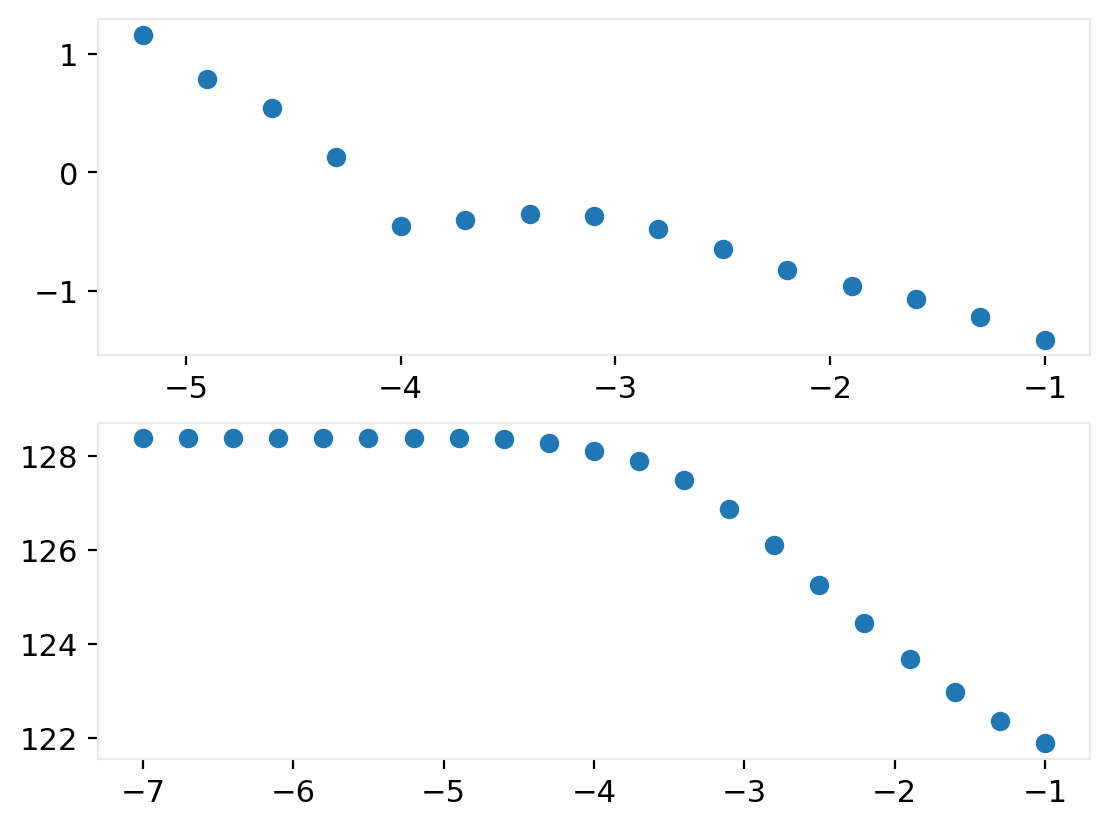

In [6]:
fig, axes = plt.subplots(2,1,dpi=200)
axes[0].scatter(np.log10(lambda_list), np.log10(P), label="P")
axes[1].scatter(np.log10(lambda_list), Ts, label="Ts")

Following the $\lambda$ suggested by P, detailed discussed in [J. Chem. Phys. 129, 194102 (2008)](https://doi.org/10.1063/1.2982799). We choose:

In [7]:
lambda_list[13]

1.2589254117941661e-05

In [8]:
# Inverter with WuYang method, guide potention v0=Fermi-Amaldi
ine.v_pbs = np.zeros_like(ine.v_pbs)
ine.invert("WuYang", opt_method="trust-exact", 
           guide_components="fermi_amaldi", reg=lambda_list[13], gtol=1e-4)

Optimization Successful within 4 iterations! |grad|=9.64e-06


In [9]:
vrest_P = ine.eng.grid.ao(ine.v_pbs, grid=grids, basis=ine.eng.pbs)
vxc_P = vFA + vrest_P - vH

Following the $\lambda$ suggested by Ts (the edge of the L curve in the bottom panel)

In [10]:
lambda_list[12]

2.5118864315095822e-05

In [11]:
# Inverter with WuYang method, guide potention v0=Fermi-Amaldi
ine.v_pbs = np.zeros_like(ine.v_pbs)
ine.invert("WuYang", opt_method="trust-exact", 
           guide_components="fermi_amaldi", 
           reg=lambda_list[12], gtol=1e-4)

Optimization Successful within 4 iterations! |grad|=1.50e-06


In [12]:
vrest_Ts = ine.eng.grid.ao(ine.v_pbs, grid=grids, basis=ine.eng.pbs)
vxc_Ts = vFA + vrest_Ts - vH

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
/var/folders/ds/n2806b452yv63hlbjdqg20400000gp/T/ipykernel_35242/2136173848.py:3: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(x, vxc, label="$\lambda=0$", ls='--')
/var/folders/ds/n2806b452yv63hlbjdqg20400000gp/T/ipykernel_35242/2136173848.py:4: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(x, vxc_P, label="$\lambda=%.2e$"%lambda_list[13], ls='--')
/var/folders/ds/n2806b452yv63hlbjdqg20400000gp/T/ipykernel_35242/2136173848.py:5: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(x, vxc_Ts, label="$\lambda=%.2e$"%lambda_list[14], ls='--')


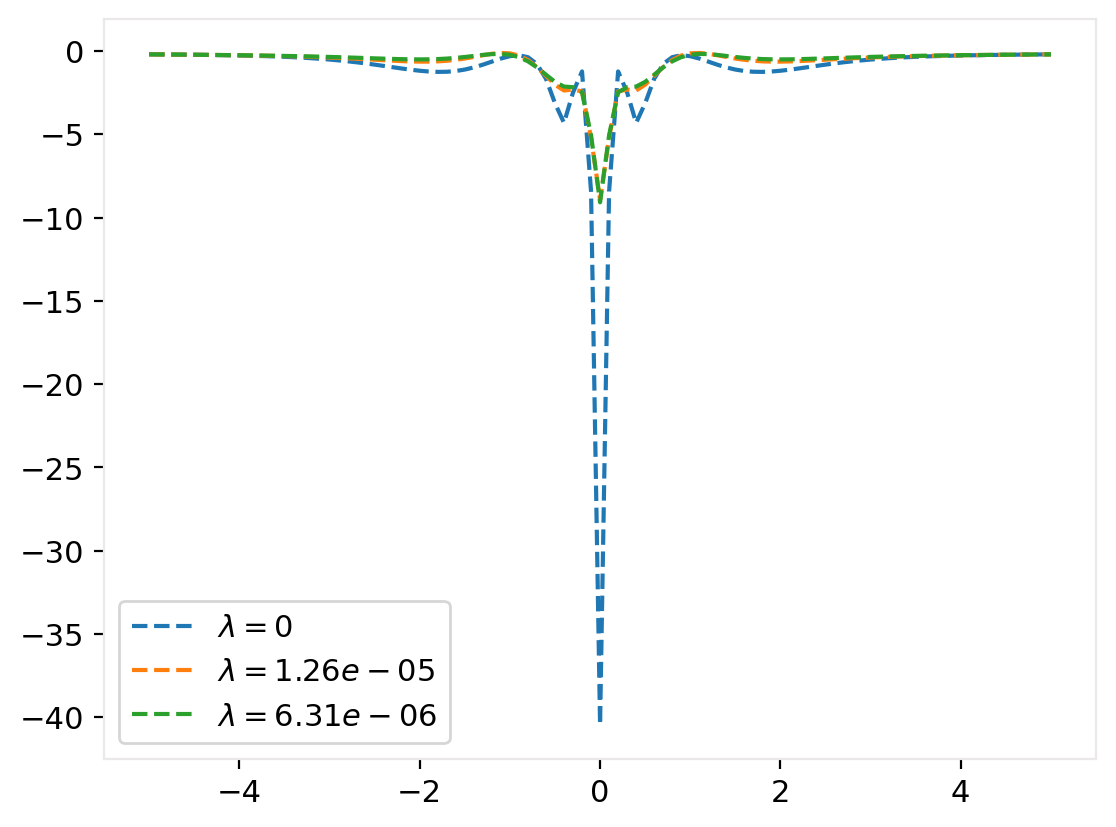

In [15]:
fig, ax = plt.subplots(dpi=200)
# ax.plot(xyz, vxc_exact, label="exact")
ax.plot(x, vxc, label="$\lambda=0$", ls='--')
ax.plot(x, vxc_P, label="$\lambda=%.2e$"%lambda_list[13], ls='--')
ax.plot(x, vxc_Ts, label="$\lambda=%.2e$"%lambda_list[14], ls='--')
ax.legend()